In [98]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("error")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11,4),
    titlesize=18,
    titleweight='bold',
)

plt.rc(
    "axes",
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=16,
    titlepad=10,
)

plot_params=dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

data_dir = Path("/Users/ganeshpanth/Projects/")
store_sales = pd.read_csv(
        data_dir/"train.csv",
        usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
        dtype={
            'store_nbr' : 'category',
            'family' : 'category',
            'sales' : 'float32'
        },
        parse_dates=['date'],
        infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family','date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

family_sales.head()

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124084   10.629630  1711.907349  1204.203735  404.300079   
2017-01-04   594.160583   11.185185  1508.036987  1107.796265  309.397675   
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   

            ... onpromotion                                       \
family      ...   MAGAZINES     MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-01  ...         0.0  0.018519      0.111111     0.018519   
2017-01-02  ...         0.0  0.462963     10.592593     0.537037   
2017-01-03  ...         0.0  0.481481      9.722222     0.444444   
2017-01-04  ...         0.0  0.370370     12.037037     0.444444   
2017-01-05  ...         0.0  8.981481      5.666667     0.000000   

                                                                         \
family     PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS     PRODUCE   
date                                                                      
2017-01-01                     0.0  0.000000       0.037037    0.129630   
2017-01-02                     0.0  0.259259       1.166667    5.629630   
2017-01-03                     0.0  0.388889       1.351852   56.296296   
2017-01-04                     0.0  0.296296       5.444444  101.277778   
2017-01-05                     0.0  0.296296       0.907407    5.018519   

                                                 
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2017-01-01                        0.0  0.000000  
2017-01-02                        0.0  0.407407  
2017-01-03                        0.0  0.407407  
2017-01-04                        0.0  0.333333  
2017-01-05                        0.0  0.444444  

[5 rows x 66 columns]

In [99]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None   # store column names from fit model

In [100]:
def fit(self, X_1, X_2, y):
    self.model_1.fit(X_1, y)

    y_fit = pd.DataFrame(
        self.model_1.predict(X_1),
        index=X_1.index, columns=y.columns,
    )

    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze()

    self.model_2.fit(X_2, y_resid)
    self.y_columns = y.columns

    self.y_fit = y_fit
    self.y_resid = y_resid
    
# Add method to the class
BoostedHybrid.fit = fit

In [101]:
def predict(self, X_1, X_2):
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1),
        index=X_1.index, columns=self.y_columns,
    )

    y_pred = y_pred.stack().squeeze()
    y_pred += self.model_2.predict(X_2)

    return y_pred.unstack()

# Add method to the class
BoostedHybrid.predict = predict

In [102]:
# Target Series

y = family_sales.loc[:, 'sales']

# X_1 features for LinearRegression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()

# X_2 features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()

# Label encoding for 'family'
le = LabelEncoder()
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day # sets the values as the day of the month

In [103]:
# Training the boostedhybrid model
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor(),
)

model.fit(X_1, X_2, y)
y_pred = model.predict(X_1, X_2)

y_pred = y_pred.clip(0.0)

In [108]:
# Trying different models for hybridmodel 
# For model_1
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# For model_2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

model = BoostedHybrid(
    model_1=ElasticNet(),
    model_2=KNeighborsRegressor(),
)

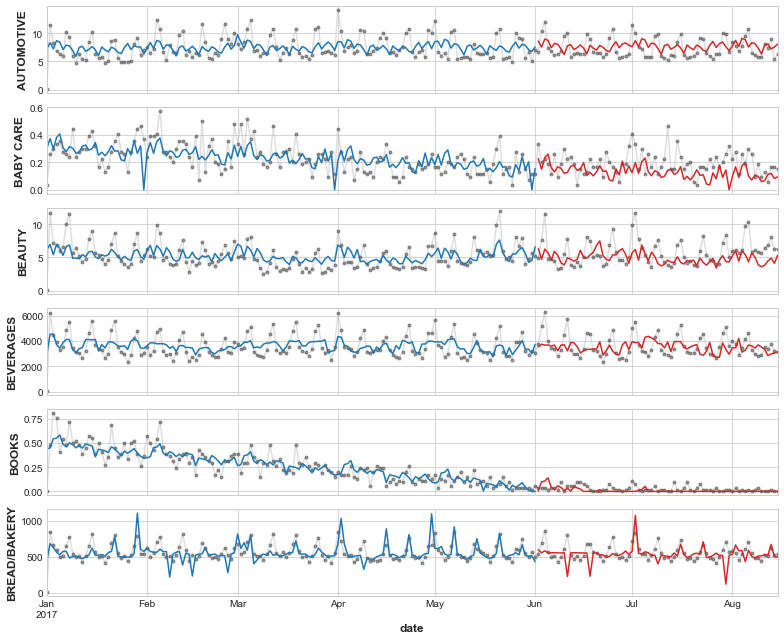

In [109]:
y_train, y_valid = y[:"2017-06-01"], y["2017-06-02":]
X1_train, X1_valid = X_1[:"2017-06-01"], X_1["2017-06-02":]
X2_train, X2_valid = X_2.loc[:"2017-06-01"], X_2.loc["2017-06-02":]

model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, color='C3', ax=axs)

for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)